# Trapped by Distance: 
## How does house price growth increase commute time for lower-income workers in the United States?

## Introduction

### Research Background

Over the past 20 years in the United States, sharply rising housing costs in urban cores have forced many low-income workers to move to suburban and rural areas, leading to longer commutes and increased transportation costs.  As affordable housing near job centers declines, workers suffer from time poverty, which refers to experiencing a lack of sufficient time to fulfill responsibilities, pursue interests, or engage in activities that contribute to one’s well-being due to various demands on their time (Travers,2024), as they must choose between paying high rent or suffering longer commute, reducing their time for work, family, and personal activities.

Previous studies have widely explored how house price growth influences commute time for lower-income workers in urban economics.  Blumenberg and Wander (2023) showed that rising housing costs in urban centers force low-income workers to relocate to suburban and exurban areas, which leads to longer commutes and increased reliance on public transportation.  This trend aggravated time poverty, where lower-income workers spend time commuting disproportionately, reducing the time available for work, education, and family (Blumenberg & King, 2019).  Also, Allen & Farber (2020) studied transport poverty and further emphasized how suburbanization limits job accessibility and increases travel costs, creating a cycle of economic hardship.  Additionally, economic cycles influence urban geography, with gentrification during boom periods accelerating displacement and commute burdens for low-income workers (Hochstenbach & Musterd, 2016).

### Research Question

To understand these changes in social welfare, the research question we want to study is, “How does house price growth increase commute time for lower-income workers in the United States?”. We choose two datasets to answer this question: The Zillow dataset with historical and current housing market data at county level; IPUMS, the 2005 to 2023 USA census data at individual-level records. 

### Variable Selection

To explore this research question, we would choose **Commute Time** (The total time a worker travels to work) as the independent variable. The most important dependent variable would be the **Yearly House Price Growth Rate**(yearly percentage increase in home values in workers' working county) as essential for analyzing the research question. In addition, we find five more dependent variables, **Workers' Residence Metropolitan Status** (urban core, suburb, or non-metropolitan area) to find whether house prices push workers to reside in suburban or rural areas, **Work Transportation**(primary mode of commuting) to find if the county's public transportation is sufficient to relieve the commute pressure for the suburb workers, and departure time to work (hour workers leaves for work) to find whether low-income workers are forced to commute early, which decreases their daily personal time, and **Family Annual Income**, **Poverty Percentage** (How much a worker’s income exceeds or falls below the poverty threshold)  as economic indicators to control the observed effect.

### Findings

Rising house prices in urban cores push lower-income workers to the suburbs, leading to longer commutes, greater reliance on public transportation, and increased time poverty.

## Data Cleaning/Loading

### Environment Setup

In [2]:
!pip install nbconvert --quiet

In [3]:
!pip install pyppeteer --quiet

In [4]:
! pip install -q qeds --quiet

In [5]:
!pip install geopandas -qq

In [6]:
import pandas as pd
import geopandas as gpd
import qeds
%matplotlib inline
import requests
from IPython.display import display
import datetime as dt
from shapely.geometry import Point
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.formula.api as sm
from pandas_datareader import DataReader
import warnings
from sklearn.linear_model import LinearRegression
import seaborn as sns
warnings.filterwarnings("ignore")

### Load Data

Load the housing market dataset.

In [7]:
file_path = "https://files.zillowstatic.com/research/public_csvs/\
zhvi/County_zhvi_uc_sfrcondo_tier_0.33_0.67_sm_sa_month.csv?t=1738696833"
hp = pd.read_csv(file_path)

Load the 2005 to 2023 US Census Data.

In [8]:
file_path = "/Users/shenxiner1/Downloads/ECO225/ECO225 \
Project/Data/usa_00024.csv.gz"
census_data = pd.read_csv(file_path, compression='gzip')
census_data = pd.DataFrame(census_data)
census_data.head()

,YEAR,MULTYEAR,SAMPLE,SERIAL,CBSERIAL,HHWT,CLUSTER,STATEFIP,COUNTYFIP,PUMA,...,PERNUM,PERWT,AGE,FTOTINC,POVERTY,PWSTATE2,PWCOUNTY,TRANWORK,TRANTIME,DEPARTS
0,2006,NaN,200601,16,1139,461.38,2006000000161,1,0,700,...,1,451.35,33,103100,501,1,0,10,5,622
1,2006,NaN,200601,16,1139,461.38,2006000000161,1,0,700,...,2,1093.27,25,103100,501,1,0,10,5,802
2,2006,NaN,200601,26,1750,310.93,2006000000261,1,0,2100,...,1,310.93,33,70000,296,0,0,0,0,0
3,2006,NaN,200601,26,1750,310.93,2006000000261,1,0,2100,...,2,491.47,33,70000,296,1,0,80,0,0
4,2006,NaN,200601,26,1750,310.93,2006000000261,1,0,2100,...,3,210.63,8,70000,296,0,0,0,0,0


### Dataset Pre-Processing

Remove the County string from the Region Name variable for future merging.

In [9]:
hp['RegionName'] = hp['RegionName'].str.replace("County", "", regex=True).str.strip()

Convert the Date column in the reshaped DataFrame to a proper date format

In [10]:
id_vars = ['RegionID', 'SizeRank', 'RegionName', 'RegionType', 'StateName', 'State', 
           'Metro', 'StateCodeFIPS', 'MunicipalCodeFIPS']
hp_melted = pd.melt(hp, id_vars=id_vars, var_name='Date', value_name='Zillow Home Value Index (ZHVI)')
hp_melted['Date'] = pd.to_datetime(hp_melted['Date'], errors='coerce')
hp_melted['Year'] = hp_melted['Date'].dt.year
hp_melted['Year'] =hp_melted.Year.astype(int)
hp_melted.head()

,RegionID,SizeRank,RegionName,RegionType,StateName,State,Metro,StateCodeFIPS,MunicipalCodeFIPS,Date,Zillow Home Value Index (ZHVI),Year
0,3101,0,Los Angeles,county,CA,CA,"Los Angeles-Long Beach-Anaheim, CA",6,37,2000-01-31,205554.642143,2000
1,139,1,Cook,county,IL,IL,"Chicago-Naperville-Elgin, IL-IN-WI",17,31,2000-01-31,146088.131319,2000
2,1090,2,Harris,county,TX,TX,"Houston-The Woodlands-Sugar Land, TX",48,201,2000-01-31,109502.880748,2000
3,2402,3,Maricopa,county,AZ,AZ,"Phoenix-Mesa-Chandler, AZ",4,13,2000-01-31,143224.384045,2000
4,2841,4,San Diego,county,CA,CA,"San Diego-Chula Vista-Carlsbad, CA",6,73,2000-01-31,213034.659393,2000


Processing the MULTYEAR variable to identify the actual year of the survey in multi-year ACS/PRCS samples, and drop observations with Commute Time equals 888, which was suppressed for data year 2023 for select PUMAs

In [11]:
census_data['MULTYEAR'] = census_data['MULTYEAR'].fillna(census_data['YEAR'])
census_data['MULTYEAR'] = census_data.MULTYEAR.astype(int)
census_data= census_data[census_data['TRANTIME'] != 888]

### Create New Columns

We create and encode new variables to standardize key variables from the Census and Housing data based on the data dictionary provided by IPUMS.

We scale family income into tens of thousands for easier interpretation and comparison.

In [12]:
census_data["tFTOTINC"] = census_data["FTOTINC"]/10000

##### Yearly Growth Rate of Zillow Home Value Index (ZHVI) by County

We calculate the Yearly Growth Rate of House Value by comparing the Zillow Home Value Index (ZHVI) from January to December for each year and region, using the formula $\frac{\text{ZHVI}{\text{Dec}} - \text{ZHVI}{\text{Jan}}}{\text{ZHVI}_{\text{Jan}}} \times$ 100 .

In [13]:
hp_melted.sort_values(by=['RegionID', 'Date'], inplace=True)

january_data = hp_melted[hp_melted['Date'].dt.month == 1]
december_data = hp_melted[hp_melted['Date'].dt.month == 12]

yearly_data = pd.merge(january_data, december_data, on=['RegionID', 'Year'], suffixes=('_start', '_end'))

yearly_data['Yearly_Growth_Rate'] = ((yearly_data['Zillow Home Value Index (ZHVI)_end'] - 
                                      yearly_data['Zillow Home Value Index (ZHVI)_start']) / 
                                      yearly_data['Zillow Home Value Index (ZHVI)_start']) * 100
yearly_data = yearly_data[['RegionID', 'Year', 'Yearly_Growth_Rate']]
hp_meltedyear = pd.merge(hp_melted, yearly_data, on=['RegionID', 'Year'], how='left')
hp_meltedyear.drop(columns=['Date'], inplace=True)
hp_meltedyear = hp_meltedyear.drop_duplicates(subset=['RegionID', 'Year'], keep='first')
hp_meltedyear = hp_meltedyear.fillna(0)

We categorize Metropolitan Status based on IPUMS metropolitan classifications.

In [14]:
def categorize_metro(metro):
    """
    Categorizes the METRO variable into broader metropolitan classifications.
    
    Parameters:
    metro (int): METRO code.

    Returns:
    str: Categorical label for metropolitan classification.
    """
    if metro == 0:
        return "Metropolitan Status Indeterminable (Mixed)"
    elif metro == 1:
        return "Not in Metropolitan Area"
    elif metro == 2:
        return "In Central/Principal City"
    elif metro == 3:
        return "Not in Central/Principal City"
    elif metro == 4:
        return "Central/Principal City Status Indeterminable (Mixed)"
    else:
        return "Unknown"

census_data["METRO"] = census_data["METRO"].apply(categorize_metro)

We encoded TRANWORK codes into transportation categories.

In [15]:
category_mapping = {
    10: 'Vehicle',  # Auto, truck, or van
    20: 'Vehicle',  # Motorcycle
    31: 'Public Transport',  # Bus
    32: 'Public Transport',  # Bus or trolley bus
    36: 'Public Transport',  # Subway or elevated
    50: 'Public Transport',  # Bicycle
    60: 'Public Transport',  # Walked only
    80: 'Public Transport'   # Worked at home
}
census_data['Work Transportation'] = census_data['TRANWORK'].map(category_mapping)

We categorize the income level by poverty line as it's largely comparable across years. We categorize income levels based on the percentage above the poverty line, ensuring a structured comparison of economic groups.

In [16]:
def categorize_income(poverty):
    if poverty <= 200 & poverty != 0:  
        return "Low Income"
    if poverty == 0:
        return "Extreme High Income"
    elif 200 < poverty <= 500:  
        return "Middle Income"
    else:  
        return "High Income"

census_data["Income Category"] = census_data["POVERTY"].apply(categorize_income)
import pandas as pd

income_order = ["Low Income", "Middle Income", "High Income", "Extreme High Income"]

census_data["Income Category"] = pd.Categorical(census_data["Income Category"], 
                                                categories=income_order, ordered=True)

We classify DEPARTS into five departure time categories, assigning “Unknown” to missing or zero.

In [17]:
def categorize_departure_time(departs):
    if departs == 0 or pd.isna(departs):  
        return "Unknown"
    elif 1 <= departs <= 559:
        return "Very Early (Midnight - 6 AM)"
    elif 600 <= departs <= 859:
        return "Early Morning (6 AM - 9 AM)"
    elif 900 <= departs <= 1159:
        return "Mid-Morning (9 AM - 12 PM)"
    elif 1200 <= departs <= 1659:
        return "Afternoon (12 PM - 5 PM)"
    else:
        return "Evening/Night (5 PM - Midnight)"
census_data["DEPARTS_CATEGORY"] = census_data["DEPARTS"].apply(categorize_departure_time)


### Chekcing Missing Value

In [18]:
hp_meltedyear.isnull().sum()
hp_meltedyear = hp_meltedyear.dropna()

In [19]:
census_data.isnull().sum()
census_data = census_data.dropna()

We drop the census individual data with counties unidentifiable from public-use data to ensure data usability.

In [20]:
census_data= census_data[census_data['PWCOUNTY'] != 0]

### Merge Dataset by County

Our goal is to construct a dataset that records commute time for individuals included in the census sample across the United States from 2005 to 2023, with the yearly growth rate of house prices in the county where they worked.

To achieve this, we will merge two datasets: one containing yearly growth rate at the county level and another with commute time data from the census sample, both across 2005 to 2023. 

We merge two datasets by matching work state FIP Code, work County FIP Code, and year, linking each worker’s commute time with the average house price in their work location.

In [21]:
hp_meltedyear['PWSTATE2'] = hp_meltedyear['StateCodeFIPS'].astype(int)
hp_meltedyear['PWCOUNTY'] = hp_meltedyear['MunicipalCodeFIPS'].astype(int)
census_data['Year'] = census_data['MULTYEAR']
resultmerge = pd.merge(census_data,hp_meltedyear, on=['PWSTATE2','PWCOUNTY','Year'],how="left")
resultmerge.sort_values(by=['Year','RegionName'], inplace=True)

In [22]:
resultmerge.head()

,YEAR,MULTYEAR,SAMPLE,SERIAL,CBSERIAL,HHWT,CLUSTER,STATEFIP,COUNTYFIP,PUMA,...,SizeRank,RegionName,RegionType,StateName,State,Metro,StateCodeFIPS,MunicipalCodeFIPS,Zillow Home Value Index (ZHVI),Yearly_Growth_Rate
126306,2009,2005,200905,1934267,2005000009333,239.76,2009019342675,16,1,600,...,146.0,Ada,county,ID,ID,"Boise City, ID",16.0,1.0,157473.911902,14.395466
126307,2009,2005,200905,1934447,2005000052165,159.84,2009019344475,16,0,400,...,146.0,Ada,county,ID,ID,"Boise City, ID",16.0,1.0,157473.911902,14.395466
126308,2009,2005,200905,1934497,2005000064208,219.78,2009019344975,16,1,600,...,146.0,Ada,county,ID,ID,"Boise City, ID",16.0,1.0,157473.911902,14.395466
126309,2009,2005,200905,1934626,2005000094735,139.86,2009019346265,16,1,700,...,146.0,Ada,county,ID,ID,"Boise City, ID",16.0,1.0,157473.911902,14.395466
126311,2009,2005,200905,1934706,2005000112662,269.73,2009019347065,16,1,600,...,146.0,Ada,county,ID,ID,"Boise City, ID",16.0,1.0,157473.911902,14.395466


Finally, we check for missing values where housing data is unavailable for certain areas and drop those observations.

In [23]:
resultmerge.isnull().sum()
resultmerge = resultmerge.dropna()


### Filter Columns

In [24]:
columns_to_keep = [
   'METRO', 'POVERTY', 'Work Transportation','Income Category','DEPARTS_CATEGORY',
    'TRANTIME', 'DEPARTS', 'tFTOTINC', 
    'Year', 'RegionName', 'State', 'Metro','Yearly_Growth_Rate'
]
resultmerge = resultmerge[columns_to_keep]
resultmerge = pd.DataFrame(resultmerge)

## Summary Statistics Tables

#### Summary Statistics of numerical variables by Residence Metropolitan Status within each Income Category

In [25]:
interest_variable = ['METRO', 'TRANTIME','Income Category']
merge_interest = pd.DataFrame(resultmerge[interest_variable])
merge_interest.groupby(["METRO","Income Category"]).describe().round(2)

TRANTIME                \
                                                      count   mean    std   
METRO                         Income Category                               
In Central/Principal City     Low Income             2338.0  27.03  23.55   
                              Middle Income        124051.0  27.19  22.72   
                              High Income          190899.0  26.21  22.49   
                              Extreme High Income    6567.0  15.28  20.69   
Not in Central/Principal City Low Income             3049.0  24.56  22.16   
                              Middle Income        278150.0  26.04  21.98   
                              High Income          422090.0  26.84  22.96   
                              Extreme High Income    7272.0  13.01  18.24   
Not in Metropolitan Area      Low Income              299.0  34.64  32.59   
                              Middle Income         25517.0  34.97  30.07   
                              High Income           24663.0  35.68  32.30   
                              Extreme High Income     465.0  15.57  21.31   

                                                                          \
                                                   min   25%   50%   75%   
METRO                         Income Category                              
In Central/Principal City     Low Income           0.0  12.0  20.0  35.0   
                              Middle Income        0.0  15.0  20.0  35.0   
                              High Income          0.0  10.0  20.0  35.0   
                              Extreme High Income  0.0   5.0  10.0  20.0   
Not in Central/Principal City Low Income           0.0  10.0  20.0  30.0   
                              Middle Income        0.0  10.0  20.0  34.0   
                              High Income          0.0  10.0  20.0  35.0   
                              Extreme High Income  0.0   3.0   7.0  15.0   
Not in Metropolitan Area      Low Income           0.0  15.0  30.0  45.0   
                              Middle Income        0.0  15.0  30.0  45.0   
                              High Income          0.0  15.0  30.0  45.0   
                              Extreme High Income  0.0   5.0  10.0  20.0   

                                                          
                                                     max  
METRO                         Income Category             
In Central/Principal City     Low Income           185.0  
                              Middle Income        200.0  
                              High Income          197.0  
                              Extreme High Income  182.0  
Not in Central/Principal City Low Income           182.0  
                              Middle Income        197.0  
                              High Income          200.0  
                              Extreme High Income  185.0  
Not in Metropolitan Area      Low Income           200.0  
                              Middle Income        200.0  
                              High Income          200.0  
                              Extreme High Income  195.0

In [26]:
interest_variable = ['METRO','DEPARTS','Income Category']
merge_interest = pd.DataFrame(resultmerge[interest_variable])
merge_interest.groupby(["METRO","Income Category"]).describe().round(2)

DEPARTS                  \
                                                      count    mean     std   
METRO                         Income Category                                 
In Central/Principal City     Low Income             2338.0  841.11  429.26   
                              Middle Income        124051.0  802.02  405.10   
                              High Income          190899.0  765.54  396.24   
                              Extreme High Income    6567.0  902.99  562.06   
Not in Central/Principal City Low Income             3049.0  844.94  439.87   
                              Middle Income        278150.0  784.55  402.06   
                              High Income          422090.0  739.20  380.78   
                              Extreme High Income    7272.0  828.20  542.95   
Not in Metropolitan Area      Low Income              299.0  796.97  434.12   
                              Middle Income         25517.0  771.30  399.35   
                              High Income           24663.0  759.01  383.75   
                              Extreme High Income     465.0  996.26  530.62   

                                                                              \
                                                   min    25%    50%     75%   
METRO                         Income Category                                  
In Central/Principal City     Low Income           0.0  632.0  747.0   932.0   
                              Middle Income        0.0  632.0  732.0   902.0   
                              High Income          0.0  632.0  732.0   847.0   
                              Extreme High Income  0.0  602.0  842.0  1335.0   
Not in Central/Principal City Low Income           0.0  612.0  732.0   932.0   
                              Middle Income        0.0  602.0  717.0   832.0   
                              High Income          0.0  602.0  717.0   832.0   
                              Extreme High Income  0.0  552.0  802.0  1205.0   
Not in Metropolitan Area      Low Income           0.0  602.0  702.0   832.0   
                              Middle Income        0.0  602.0  702.0   802.0   
                              High Income          0.0  602.0  702.0   802.0   
                              Extreme High Income  0.0  702.0  902.0  1405.0   

                                                           
                                                      max  
METRO                         Income Category              
In Central/Principal City     Low Income           2345.0  
                              Middle Income        2345.0  
                              High Income          2345.0  
                              Extreme High Income  2345.0  
Not in Central/Principal City Low Income           2345.0  
                              Middle Income        2345.0  
                              High Income          2345.0  
                              Extreme High Income  2345.0  
Not in Metropolitan Area      Low Income           2235.0  
                              Middle Income        2345.0  
                              High Income          2345.0  
                              Extreme High Income  2345.0

In [27]:
interest_variable = ['METRO','Income Category', 'tFTOTINC']
merge_interest = pd.DataFrame(resultmerge[interest_variable])
merge_interest.groupby(["METRO","Income Category"]).describe().round(2)

tFTOTINC                  \
                                                      count     mean    std   
METRO                         Income Category                                 
In Central/Principal City     Low Income             2338.0     2.89   1.86   
                              Middle Income        124051.0     6.75   3.14   
                              High Income          190899.0    13.60  14.35   
                              Extreme High Income    6567.0  1000.00   0.00   
Not in Central/Principal City Low Income             3049.0     3.32   1.95   
                              Middle Income        278150.0     7.51   3.18   
                              High Income          422090.0    15.41  12.60   
                              Extreme High Income    7272.0  1000.00   0.00   
Not in Metropolitan Area      Low Income              299.0     3.37   1.78   
                              Middle Income         25517.0     6.81   2.65   
                              High Income           24663.0    11.03   9.49   
                              Extreme High Income     465.0  1000.00   0.00   

                                                                              \
                                                       min      25%      50%   
METRO                         Income Category                                  
In Central/Principal City     Low Income              0.08     1.54     2.44   
                              Middle Income           1.95     4.50     6.05   
                              High Income            -2.20     3.45    10.55   
                              Extreme High Income  1000.00  1000.00  1000.00   
Not in Central/Principal City Low Income              0.08     1.94     3.05   
                              Middle Income           1.91     5.18     6.99   
                              High Income            -2.94     8.49    13.12   
                              Extreme High Income  1000.00  1000.00  1000.00   
Not in Metropolitan Area      Low Income              0.09     2.01     3.26   
                              Middle Income           2.07     4.95     6.46   
                              High Income            -1.91     4.09     9.93   
                              Extreme High Income  1000.00  1000.00  1000.00   

                                                                     
                                                       75%      max  
METRO                         Income Category                        
In Central/Principal City     Low Income              3.87    10.32  
                              Middle Income           8.20    30.26  
                              High Income            17.39   226.61  
                              Extreme High Income  1000.00  1000.00  
Not in Central/Principal City Low Income              4.42    12.20  
                              Middle Income           9.30    32.17  
                              High Income            18.99   192.72  
                              Extreme High Income  1000.00  1000.00  
Not in Metropolitan Area      Low Income              4.31     9.35  
                              Middle Income           8.20    22.69  
                              High Income            14.12   149.04  
                              Extreme High Income  1000.00  1000.00

In [28]:
interest_variable = ['METRO','Income Category','Yearly_Growth_Rate']
merge_interest = pd.DataFrame(resultmerge[interest_variable])
merge_interest.groupby(["METRO","Income Category"]).describe().round(2)

Yearly_Growth_Rate        \
                                                               count  mean   
METRO                         Income Category                                
In Central/Principal City     Low Income                      2338.0  2.25   
                              Middle Income                 124051.0  3.12   
                              High Income                   190899.0  3.17   
                              Extreme High Income             6567.0  3.58   
Not in Central/Principal City Low Income                      3049.0  2.81   
                              Middle Income                 278150.0  2.94   
                              High Income                   422090.0  2.86   
                              Extreme High Income             7272.0  3.18   
Not in Metropolitan Area      Low Income                       299.0  2.18   
                              Middle Income                  25517.0  2.08   
                              High Income                    24663.0  2.17   
                              Extreme High Income              465.0  2.20   

                                                                            \
                                                    std    min   25%   50%   
METRO                         Income Category                                
In Central/Principal City     Low Income           8.13 -38.94 -2.86  3.40   
                              Middle Income        7.51 -38.94 -1.32  3.75   
                              High Income          7.39 -42.93 -1.20  3.69   
                              Extreme High Income  6.39 -38.94 -0.10  4.49   
Not in Central/Principal City Low Income           8.04 -33.55 -2.03  3.64   
                              Middle Income        7.86 -42.93 -1.19  3.60   
                              High Income          7.58 -38.94 -1.09  3.50   
                              Extreme High Income  6.25 -33.55  0.44  3.72   
Not in Metropolitan Area      Low Income           7.48 -20.40 -0.36  1.67   
                              Middle Income        6.54 -30.42 -1.26  1.82   
                              High Income          6.95 -38.94 -1.07  2.08   
                              Extreme High Income  6.67 -25.42 -1.58  3.10   

                                                                
                                                    75%    max  
METRO                         Income Category                   
In Central/Principal City     Low Income           6.72  31.24  
                              Middle Income        7.14  41.66  
                              High Income          7.20  41.66  
                              Extreme High Income  7.66  29.66  
Not in Central/Principal City Low Income           7.21  33.00  
                              Middle Income        7.19  54.67  
                              High Income          7.03  54.67  
                              Extreme High Income  6.80  37.14  
Not in Metropolitan Area      Low Income           5.62  54.67  
                              Middle Income        5.31  54.67  
                              High Income          5.45  54.67  
                              Extreme High Income  6.12  54.67

This summary statistic table shows the pattern of commute time, departure time, family income, and yearly housing price growth rates across different metropolitan statuses and income categories.

The table shows that lower-income workers are increasingly living in suburban areas, where they face commute times averaging 26.84 minutes, slightly lower than in urban cores (27.03 minutes). Suburban low-income workers also have lower family incomes ($\$$3.32K) compared to urban core residents ($\$$6.75K). Also, house prices in urban cores have grown the fastest (3.17% on average), outpacing suburban (2.94%) and non-metro (2.08%) areas, suggesting that rising urban housing costs are pushing lower-income workers outward. This shift contributes to time poverty as workers must trade affordability for longer commutes. 

Overall, the table highlights the suburbanization of lower-income workers, who face long commute times and relatively high transportation burdens. 

#### Count and proportion of residence Metro Type within each Income Category

In [29]:
count_df = resultmerge.groupby("Income Category")["METRO"].value_counts().unstack()

proportion_df = resultmerge.groupby("Income Category")["METRO"].value_counts(normalize=True).unstack() * 100
summary_df = count_df.astype(str) + " (" + proportion_df.round(2).astype(str) + "%)"
summary_df

METRO,In Central/Principal City,Not in Central/Principal City,Not in Metropolitan Area
Income Category,,,
Low Income,2338 (41.12%),3049 (53.62%),299 (5.26%)
Middle Income,124051 (29.0%),278150 (65.03%),25517 (5.97%)
High Income,190899 (29.94%),422090 (66.19%),24663 (3.87%)
Extreme High Income,6567 (45.91%),7272 (50.84%),465 (3.25%)


The table shows that most workers, regardless of income, live in suburban areas. Over half (53.62%) of low-income workers live in the suburbs, while only 41.12% remain in urban cores, suggesting that many lower-income individuals are priced out of city centers.  Meanwhile, non-metro areas have the smallest share of workers, with only 5-6% across all income levels, highlighting the dominance of suburban living, especially for lower-income households.

## Plots, Histograms, Figures

### Distribution of Household's Commute Time

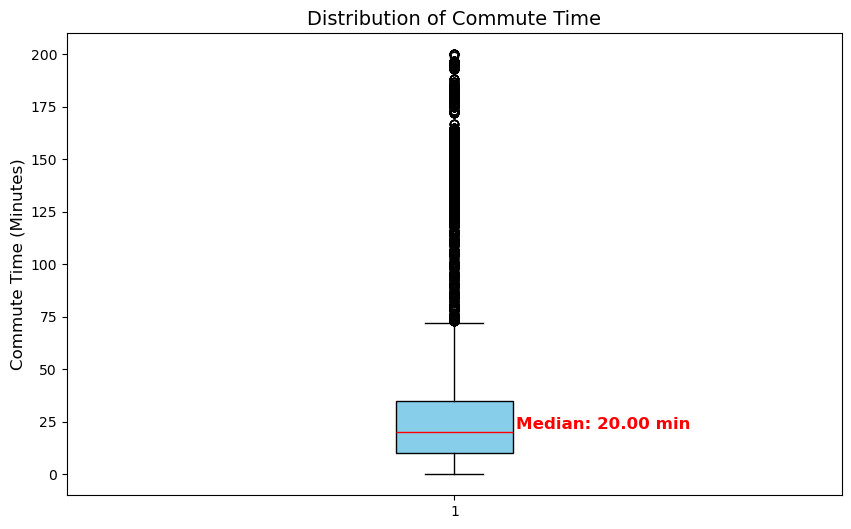

In [30]:
plt.figure(figsize=(10, 6))
plt.boxplot(resultmerge["TRANTIME"], patch_artist=True, 
            boxprops=dict(facecolor='skyblue', color='black'),
            medianprops=dict(color='red'))
median_commute = np.median(resultmerge["TRANTIME"].dropna())
plt.text(1.08, median_commute, f'Median: {median_commute:.2f} min', 
         verticalalignment='bottom', color='red', fontsize=12, fontweight='bold')
plt.ylabel('Commute Time (Minutes)', fontsize=12)
plt.title('Distribution of Commute Time', fontsize=14)

plt.show()

From this plot, we find out that the median commute time is 20 minutes, while 75% of the households commute for about 75 minutes. Also, we can see that there are so many outliers exceeding 75 up to 200 minutes. This suggests a substantial group of extreme commuters, which verifies concerns about time poverty.

### Distribution of Yearly Growth Rate of Housing Value (Main Predictor) at Household’s Working County

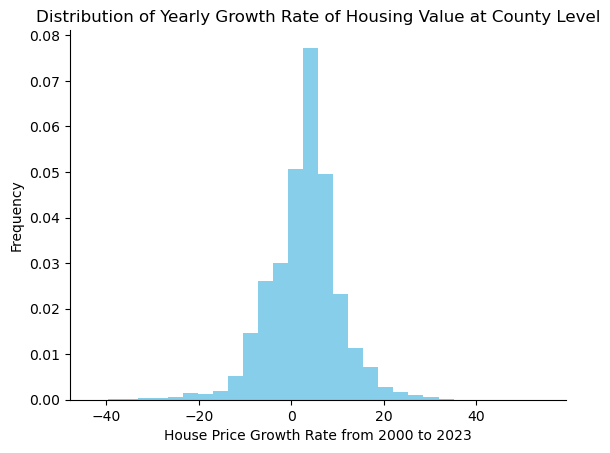

In [31]:
fig, ax = plt.subplots()
resultmerge.plot(
    kind="hist", y="Yearly_Growth_Rate", color='skyblue',
    bins=30, legend=False, density=True, ax=ax
)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.xlabel('House Price Growth Rate from 2000 to 2023')
plt.ylabel('Frequency')
plt.title('Distribution of Yearly Growth Rate of Housing Value at County Level')
plt.show()

This histogram shows that the yearly house price growth rates at the county level from 2000 to 2023 exhibit moderate growth rates centered around 0% for the majority of counties and years. However, there are notable cases of both negative and extreme positive growth rates, suggesting periods of housing market downturns and booms. 

### Relationship between Commute Time and Predictors

#### Yearly Growth Rate of Housing Value at Working County, Residence Metropolitan Status, Work Transportation

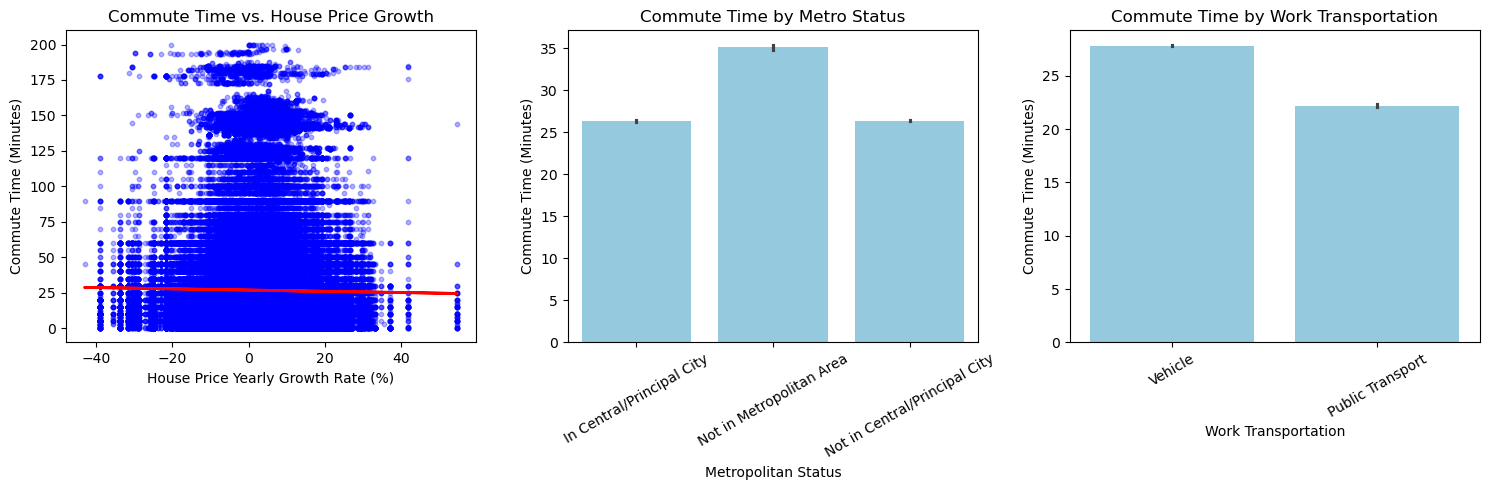

In [32]:
bar_color = "skyblue"
scatter_color = "blue"
line_color = "red"

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

X1 = resultmerge["Yearly_Growth_Rate"].values.reshape(-1, 1)
y1 = resultmerge["TRANTIME"].values.reshape(-1, 1)
lr1 = LinearRegression().fit(X1, y1)
y_pred1 = lr1.predict(X1)

axes[0].scatter(resultmerge["Yearly_Growth_Rate"], resultmerge["TRANTIME"], color=scatter_color, alpha=0.3, s=10)
axes[0].plot(resultmerge["Yearly_Growth_Rate"], y_pred1, color=line_color, linewidth=2)
axes[0].set_title("Commute Time vs. House Price Growth")
axes[0].set_xlabel("House Price Yearly Growth Rate (%)")
axes[0].set_ylabel("Commute Time (Minutes)")

sns.barplot(data=resultmerge, x="METRO", y="TRANTIME", ax=axes[1], color=bar_color)
axes[1].set_title("Commute Time by Metro Status")
axes[1].set_xlabel("Metropolitan Status")
axes[1].set_ylabel("Commute Time (Minutes)")
axes[1].tick_params(axis='x', rotation=30)

sns.barplot(data=resultmerge, x="Work Transportation", y="TRANTIME", ax=axes[2], color=bar_color)
axes[2].set_title("Commute Time by Work Transportation")
axes[2].set_xlabel("Work Transportation")
axes[2].set_ylabel("Commute Time (Minutes)")
axes[2].tick_params(axis='x', rotation=30)


plt.tight_layout()
plt.show()

#### Departure Hour, Annual Family Income, Poverty Level

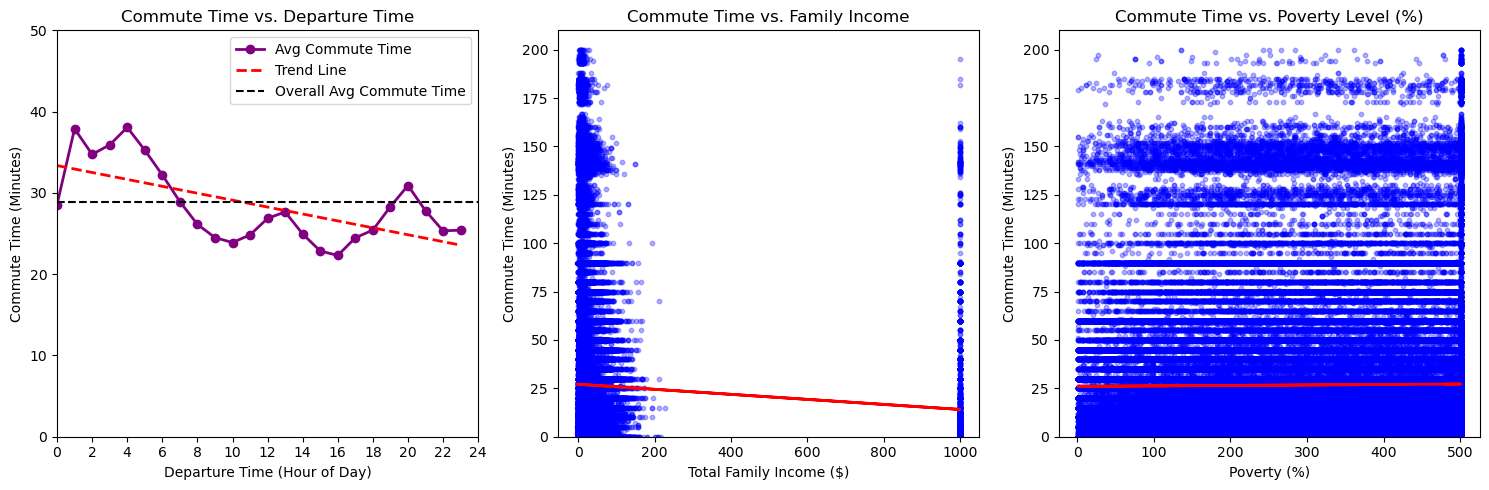

In [33]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

df = resultmerge[(resultmerge["DEPARTS"] != 0) & (~resultmerge["DEPARTS"].isna())].copy()

df["DEPARTS_HOUR"] = df["DEPARTS"] // 100  

departure_avg = df.groupby("DEPARTS_HOUR")["TRANTIME"].mean().reset_index()

X0 = departure_avg["DEPARTS_HOUR"].values.reshape(-1, 1)
y0 = departure_avg["TRANTIME"].values.reshape(-1, 1)
lr0 = LinearRegression().fit(X0, y0)
y_pred0 = lr0.predict(X0)

axes[0].plot(departure_avg["DEPARTS_HOUR"], departure_avg["TRANTIME"], 
             color="purple", marker="o", linestyle="-", linewidth=2, label="Avg Commute Time")

axes[0].plot(departure_avg["DEPARTS_HOUR"], y_pred0, color="red", linestyle="--", linewidth=2, label="Trend Line")

axes[0].set_title("Commute Time vs. Departure Time")
axes[0].set_xlabel("Departure Time (Hour of Day)")
axes[0].set_ylabel("Commute Time (Minutes)")
axes[0].set_xticks(range(0, 25, 2)) 
axes[0].set_xlim(0, 24) 
axes[0].set_ylim(0, 50)
axes[0].axhline(y=df["TRANTIME"].mean(), color="black", linestyle="--", label="Overall Avg Commute Time")
axes[0].legend()

X1 = resultmerge["tFTOTINC"].values.reshape(-1, 1)
y1 = resultmerge["TRANTIME"].values.reshape(-1, 1)
lr1 = LinearRegression().fit(X1, y1)
y_pred1 = lr1.predict(X1)

axes[1].scatter(resultmerge["tFTOTINC"], resultmerge["TRANTIME"], color=scatter_color, alpha=0.3, s=10)
axes[1].plot(resultmerge["tFTOTINC"], y_pred1, color=line_color, linewidth=2)
axes[1].set_title("Commute Time vs. Family Income")
axes[1].set_xlabel("Total Family Income ($)")
axes[1].set_ylabel("Commute Time (Minutes)")
axes[1].set_ylim(0, 210)

resultmerge_poverty = resultmerge[resultmerge['POVERTY'] != 0]
X2 = resultmerge_poverty["POVERTY"].values.reshape(-1, 1)
y2 = resultmerge_poverty["TRANTIME"].values.reshape(-1, 1)
lr2 = LinearRegression().fit(X2, y2)
y_pred2 = lr2.predict(X2)

axes[2].scatter(resultmerge_poverty["POVERTY"], resultmerge_poverty["TRANTIME"], color=scatter_color,
                alpha=0.3, s=10)
axes[2].plot(resultmerge_poverty["POVERTY"], y_pred2, color=line_color, linewidth=2)
axes[2].set_title("Commute Time vs. Poverty Level (%)")
axes[2].set_xlabel("Poverty (%)")
axes[2].set_ylabel("Commute Time (Minutes)")
axes[2].set_ylim(0, 210)

plt.tight_layout()
plt.show()

The above six graphs show the relationship between commute time and key predictors.  The scatter plots state that as the percentage above the poverty line and the house price growth rate increase, commute times tend to slightly rise, while the increase in total family income significantly decreases the commute time.  The line chart on departure time shows that workers who depart to work early in the day experience longer commutes, much higher than the average commute time, and the average commute time tends to decrease at the later hour of the day.   The bar charts of ways workers transport to work and the metropolitan status of workers' residences further highlight differences in commute times.  Workers who commute by car have longer commute times, which shows that developing public transportation might be a good way to decrease the commute pressure for workers.  Also, the workers living in the suburbs have significantly higher commute pressure than those living in the urban core.  This suggests that rising house prices may increase commuting pressure by pushing workers out of urban cores into suburban areas. This finding aligns with our literature review, which highlights that suburban residents typically face longer commute times, exacerbating time scarcity and limiting their economic and social mobility.

#### Proportion of Low-Income Workers’ Residence and House Price Growth by Metro Status Over Time

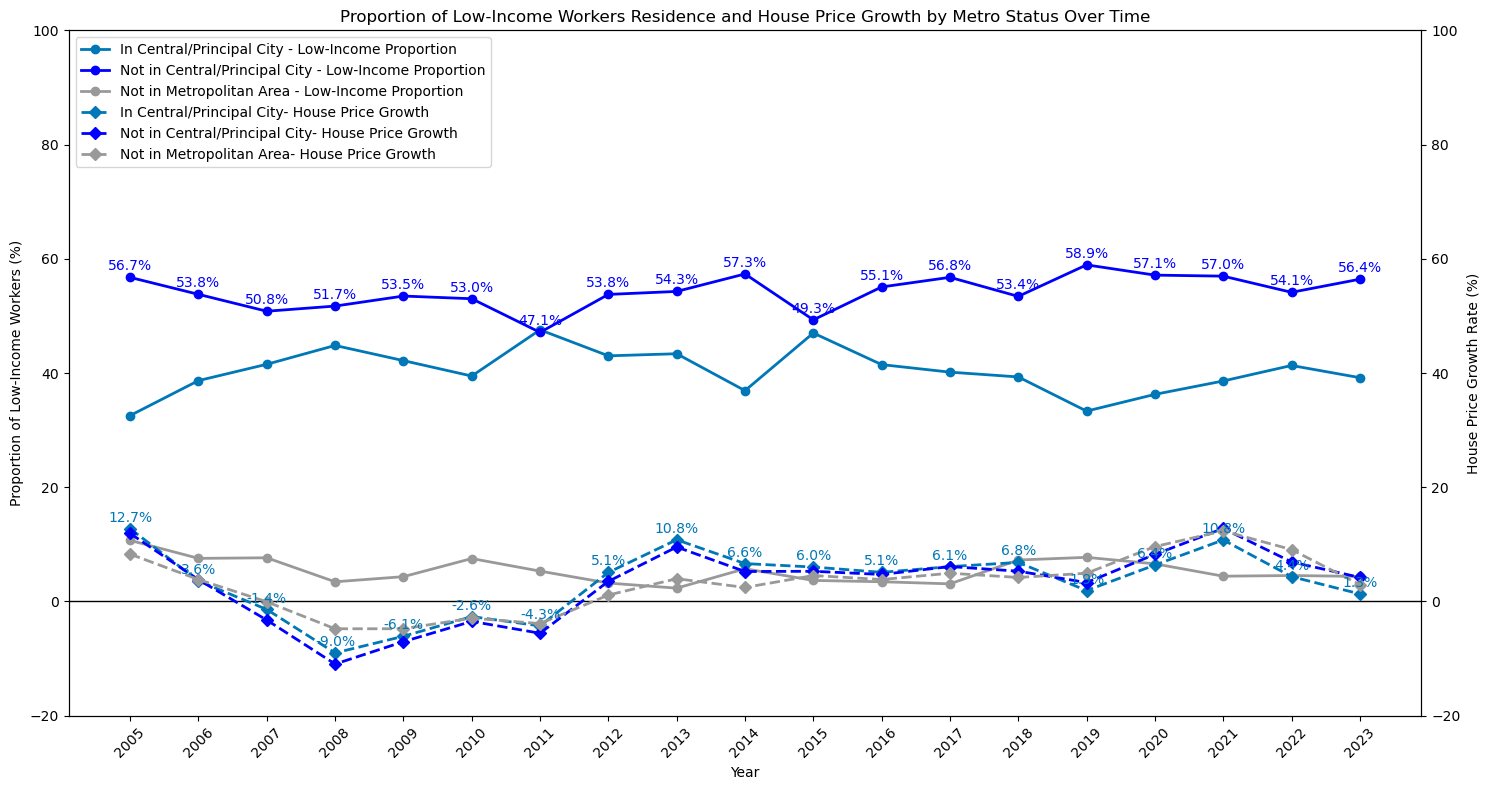

In [34]:
low_income_count = resultmerge[resultmerge["Income Category"] == "Low Income"].groupby(["Year", "METRO"]).size()
total_low_income_per_year = resultmerge[resultmerge["Income Category"] == "Low Income"].groupby("Year").size()
low_income_percentage_metro = (low_income_count / total_low_income_per_year) * 100
low_income_percentage_metro = low_income_percentage_metro.unstack()

house_price_growth_metro = resultmerge.groupby(["Year", "METRO"])["Yearly_Growth_Rate"].mean().unstack()

metro_colors = { 
    "Not in Central/Principal City": "blue",
    "In Central/Principal City": "#0077b6",
    "Not in Metropolitan Area": "#999999"
}

fig, ax1 = plt.subplots(figsize=(15, 8))

for metro_status in low_income_percentage_metro.columns:
    ax1.plot(low_income_percentage_metro.index, low_income_percentage_metro[metro_status], 
             marker="o", linestyle="-", linewidth=2, color=metro_colors.get(metro_status, "gray"), 
             label=f"{metro_status} - Low-Income Proportion")
    if metro_status == "Not in Central/Principal City":
        for year, value in zip(low_income_percentage_metro.index, low_income_percentage_metro[metro_status]):
            ax1.annotate(f"{value:.1f}%", (year, value), textcoords="offset points", xytext=(0, 5), ha="center",
                         fontsize=10, 
                         color=metro_colors.get(metro_status, "gray"))

ax1.set_xlabel("Year")
ax1.set_ylabel("Proportion of Low-Income Workers (%)")
ax1.set_ylim(-20, 100)

ax2 = ax1.twinx()
for metro_status in house_price_growth_metro.columns:
    ax2.plot(house_price_growth_metro.index, house_price_growth_metro[metro_status], 
             marker="D", linestyle="--", linewidth=2, color=metro_colors.get(metro_status, "gray"),
             label=f"{metro_status}- House Price Growth")

    if metro_status == "In Central/Principal City":
        for year, value in zip(house_price_growth_metro.index, house_price_growth_metro[metro_status]):
            ax2.annotate(f"{value:.1f}%", (year, value), textcoords="offset points", xytext=(0, 5),
                         ha="center", fontsize=10, 
                         color=metro_colors.get(metro_status, "gray"))

ax2.set_ylabel("House Price Growth Rate (%)")
ax2.set_ylim(-20, 100)

plt.title("Proportion of Low-Income Workers Residence and House Price Growth by Metro Status Over Time")
ax1.axhline(0, color='black', linestyle='-', linewidth=1)

ax1.set_xticks(low_income_percentage_metro.index)
ax1.set_xticklabels(low_income_percentage_metro.index, rotation=45)

handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
handles = handles1 + handles2
labels = labels1 + labels2

ax1.legend(handles, labels, loc="upper left")

plt.tight_layout()
plt.show()

This graph shows the trend in housing price growth and the distribution of low-income workers' residence across metropolitan areas over time. We find out that there are sharp increases in the house price growth rate in urban cores in a certain period, which leads to the proportion of low-income workers living in suburban areas rising at the same time. 
This suggests that as housing prices rise in urban cores, lower-income workers may be increasingly pushed out to suburban areas where housing is more affordable. However, we find out that, though the growth rate goes back to a normal level, the proportion of low-income workers in suburbs remains persistently high. This shows that once workers are forced relocation to farther from job centers, they do not easily return, even if housing markets cool down, leading to a shift in the residential patterns of low-income workers, thus longer commutes.

### Impact of Working County Housing Price Growth on Commute Time by Income Levels

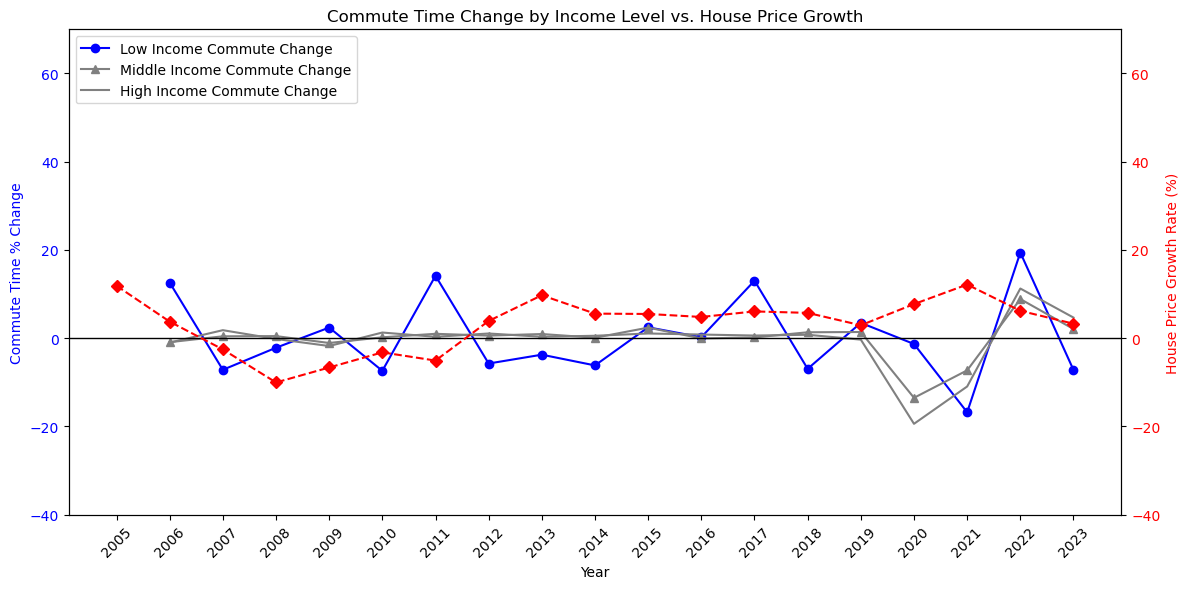

In [35]:
yearly_commute = resultmerge.groupby(["Year", "Income Category"])["TRANTIME"].mean().unstack()

yearly_commute_change = yearly_commute.pct_change() * 100

yearly_growth = resultmerge.groupby("Year")["Yearly_Growth_Rate"].mean()
fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.plot(yearly_commute_change.index, yearly_commute_change["Low Income"], 
         color="blue", marker="o", linestyle="-", label="Low Income Commute Change")
ax1.plot(yearly_commute_change.index, yearly_commute_change["Middle Income"], 
         color="grey", marker="^",linestyle="-", label="Middle Income Commute Change")
ax1.plot(yearly_commute_change.index, yearly_commute_change["High Income"], 
         color="grey", linestyle="-", label="High Income Commute Change")

ax1.set_xlabel("Year")
ax1.set_ylabel("Commute Time % Change", color="blue")
ax1.tick_params(axis="y", labelcolor="blue")
ax1.set_ylim(-40, 70) 

ax2 = ax1.twinx()
ax2.plot(yearly_growth.index, yearly_growth, 
         color="red", marker="D", linestyle="--")
ax2.set_ylabel("House Price Growth Rate (%)", color="red")
ax2.tick_params(axis="y", labelcolor="red")
ax2.set_ylim(-40, 70) 

plt.title("Commute Time Change by Income Level vs. House Price Growth")
ax1.axhline(0, color='black', linestyle='-', linewidth=1)  # **Zero reference line**


ax1.set_xticks(yearly_commute_change.index)
ax1.set_xticklabels(yearly_commute_change.index, rotation=45)

ax1.legend(loc="upper left")

plt.tight_layout()
plt.show()

This graph compares the trend of percentage change in commute time for different income groups with the house price growth rate. We find out that low-income workers experience more fluctuations in commute time changes, suggesting that they are more sensitive to housing price shifts compared with middle and high income workers. Notably, when house price growth rises, low-income workers’ commute times tend to increase more compared to other income groups, indicating a possible displacement effect—higher housing costs may be pushing them farther from job centers. This aligns with our idea that rising house prices affect lower-income workers by forcing them into longer commutes and time poverty. 

### Family Income and Low-Income Worker Proportion by Departure Time for Work

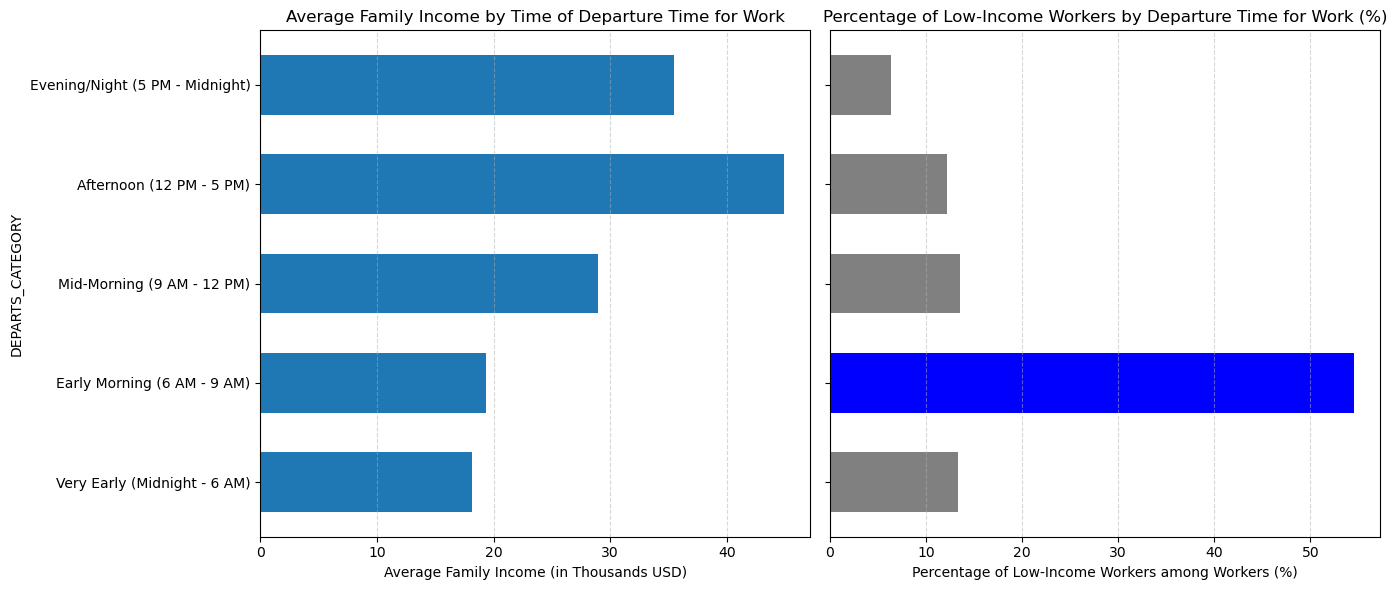

In [36]:
category_order = [
    "Very Early (Midnight - 6 AM)",
    "Early Morning (6 AM - 9 AM)",
    "Mid-Morning (9 AM - 12 PM)",
    "Afternoon (12 PM - 5 PM)",
    "Evening/Night (5 PM - Midnight)",
]

resultmerge_filtered = resultmerge[resultmerge["DEPARTS"] != 0]
resultmerge_filtered["DEPARTS_CATEGORY"] = pd.Categorical(resultmerge_filtered["DEPARTS_CATEGORY"], 
                                                          categories=category_order, ordered=True)

income_by_departure = resultmerge_filtered.groupby("DEPARTS_CATEGORY")["tFTOTINC"].mean()

departure_income_counts = resultmerge_filtered[resultmerge_filtered["Income Category"] 
== "Low Income"].groupby("DEPARTS_CATEGORY").size()
departure_income_percentage = (departure_income_counts / departure_income_counts.sum()) * 100

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14, 6), sharey=True)

income_by_departure.plot(kind="barh", ax=ax[0], width=0.6)
ax[0].set_xlabel("Average Family Income (in Thousands USD)")
ax[0].set_title("Average Family Income by Time of Departure Time for Work")
ax[0].grid(axis="x", linestyle="--", alpha=0.5)

colors = ["grey"] * len(departure_income_counts)
colors[1] = "blue" 

departure_income_percentage.plot(kind="barh", ax=ax[1], color=colors, width=0.6)
ax[1].set_xlabel("Percentage of Low-Income Workers among Workers (%)")
ax[1].set_title("Percentage of Low-Income Workers by Departure Time for Work (%)")
ax[1].grid(axis="x", linestyle="--", alpha=0.5)

plt.tight_layout()
plt.show()

The graph shows how family income and the percentage of low-income workers vary by departure time for work. 
From the two graphs, we can see that low-income workers are more likely to leave for work early in the morning, possibly due to longer travel times caused by reliance on public transportation or jobs located far from affordable housing, and those who depart early tend to have lower incomes. This connection suggests that long commutes and early departures contribute to time poverty, leaving workers with less time for rest, family, or skill-building. As a result, it becomes harder for them to improve their financial situation and escape the cycle of low income.

## Conclusion

Our analysis shows that rising urban housing costs have pushed low-income workers to the suburbs, increasing commute times and deepening time poverty. Longer commutes, especially for those relying on public transit, limit job opportunities and economic mobility. Even after housing prices stabilize, displaced workers rarely return, reinforcing long-term hardship. Expanding affordable housing and transportation access is key to reducing commute burdens.

# Reference

Steven Ruggles, Sarah Flood, Matthew Sobek, Daniel Backman, Annie Chen, Grace Cooper, Stephanie Richards, Renae Rodgers, and Megan Schouweiler. IPUMS USA: Version 15.0 [dataset]. Minneapolis, MN: IPUMS, 2024. https://doi.org/10.18128/D010.V15.0

Blumenberg, E., & Wander, M. (2023). Housing affordability and commute distance. Urban Geography, 44(7), 1454-1473. https://doi.org/10.1080/02723638.2022.2087319!

Blumenberg, E., & King, H. R. (2019). Low-income workers, residential location, and the changing commute in the United States. Built Environment, 45, 563-581. https://doi.org/10.2148/benv.45.4.563

Allen, J., & Farber, S. (2020). Suburbanization of transport poverty. Annals of the American Association of Geographers, 110(6), 1356-1372. https://doi.org/10.1080/24694452.2020.1859981

Hochstenbach, C., & Musterd, S. (2016). Changing urban geographies through boom and bust periods: Gentrification and the suburbanization of poverty. CUS Working Paper Series; No. 17. Centre for Urban Studies, University of Amsterdam. http://urbanstudies.uva.nl/working-papers/working-papers/workingpapers/content/folder/working-paper-series-no.17.html

Travers, M. (2024, March 5). A psychologist explains the concept of time poverty and offers 4 fixes. Forbes. Retrieved from https://www.forbes.com/sites/traversmark/2024/03/05/a-psychologist-explains-the-concept-of-time-poverty-and-offers-4-fixes/